<a href="https://colab.research.google.com/github/hcarrusca/diabetic_patient_trend/blob/main/Residence_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Patient at Risk of Readmission Analysis

In [120]:
pip install imbalanced-learn

In [121]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown
from imblearn.over_sampling import SMOTE

In [87]:
# Load the CSV
df = pd.read_csv('diabetic_data.csv')

# Preview data
print("Shape:", df.shape)
df.head()

Shape: (101766, 50)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


# Data Cleaning
Identifying Missing Values

In [88]:
# Count of missing or unknown values
df.replace('?', pd.NA, inplace=True)
df.replace('Unknown/Invalid', pd.NA, inplace=True)
df.replace(' ', pd.NA, inplace=True)

missing_values = df.isna().sum()
missing_values[missing_values > 0]


,0
race,2273
gender,3
weight,98569
payer_code,40256
medical_specialty,49949
diag_1,21
diag_2,358
diag_3,1423
max_glu_serum,96420
A1Cresult,84748


In [89]:
# Drop columns with too many unknowns
df_cleaned = df.drop(columns=['weight', 'payer_code', 'medical_specialty','max_glu_serum','A1Cresult'], errors='ignore')

df_cleaned.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,41,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,59,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,11,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,44,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,51,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [90]:
# Dropping the rows with missing values on the 'race' field

df_cleaned = df_cleaned.dropna(subset=['race'])
df_cleaned.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,41,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,59,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,11,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,44,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,51,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [91]:
df_cleaned.shape

(99493, 45)

# Exploring the Clean Dataset
Checking data types and unique values

In [92]:
# Check data types for each column
df_cleaned.dtypes

for col in df_cleaned.columns:
   print(f"{col}:{df_cleaned[col].dtype}")



encounter_id:int64
patient_nbr:int64
race:object
gender:object
age:object
admission_type_id:int64
discharge_disposition_id:int64
admission_source_id:int64
time_in_hospital:int64
num_lab_procedures:int64
num_procedures:int64
num_medications:int64
number_outpatient:int64
number_emergency:int64
number_inpatient:int64
diag_1:object
diag_2:object
diag_3:object
number_diagnoses:int64
metformin:object
repaglinide:object
nateglinide:object
chlorpropamide:object
glimepiride:object
acetohexamide:object
glipizide:object
glyburide:object
tolbutamide:object
pioglitazone:object
rosiglitazone:object
acarbose:object
miglitol:object
troglitazone:object
tolazamide:object
examide:object
citoglipton:object
insulin:object
glyburide-metformin:object
glipizide-metformin:object
glimepiride-pioglitazone:object
metformin-rosiglitazone:object
metformin-pioglitazone:object
change:object
diabetesMed:object
readmitted:object


In [93]:
cat_cols = df_cleaned.select_dtypes(include='object').columns

for col in cat_cols:
    print(f"\nUnique values in '{col}':")
    print(df_cleaned[col].unique())


Unique values in 'race':
['Caucasian' 'AfricanAmerican' 'Other' 'Asian' 'Hispanic']

Unique values in 'gender':
['Female' 'Male' <NA>]

Unique values in 'age':
['[0-10)' '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)'
 '[70-80)' '[80-90)' '[90-100)']

Unique values in 'diag_1':
['250.83' '276' '648' '8' '197' '414' '428' '398' '434' '250.7' '157'
 '518' '999' '410' '682' '402' 'V57' '189' '786' '427' '996' '277' '584'
 '462' '473' '411' '174' '486' '998' '511' '432' '626' '295' '196' '250.6'
 '182' '845' '423' '808' '250.4' '722' '403' '250.11' '784' '707' '440'
 '151' '715' '997' '198' '564' '38' '590' '578' '250.32' '433' '569' '185'
 '536' '255' '250.13' '599' '558' '574' '491' '560' '244' '250.03' '577'
 '730' '188' '824' '250.8' '332' '562' '291' '296' '510' '401' '263' '438'
 '70' '250.02' '493' '642' '571' '738' '593' '618' '250.42' '807' '456'
 '446' '572' '575' '250.41' '820' '515' '780' '250.22' '995' '235'
 '250.82' '721' '787' '556' '162' '724' '282' '514' 'V55

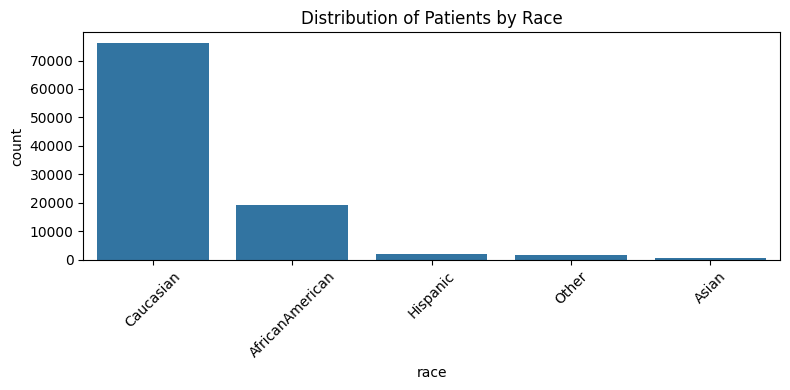

In [94]:
plt.figure(figsize=(8, 4))
sns.countplot(data=df_cleaned, x='race', order=df_cleaned['race'].value_counts().index)
plt.title('Distribution of Patients by Race')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

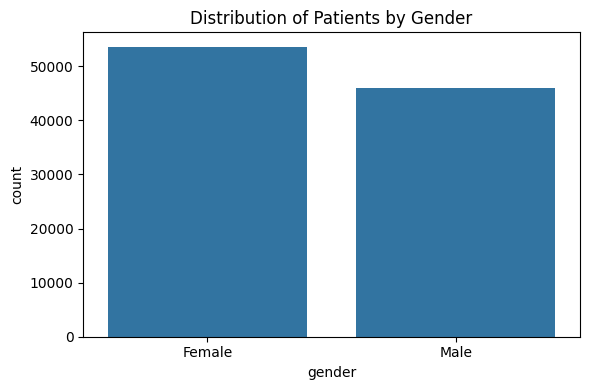

In [95]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df_cleaned, x='gender', order=df_cleaned['gender'].value_counts().index)
plt.title('Distribution of Patients by Gender')
plt.tight_layout()
plt.show()

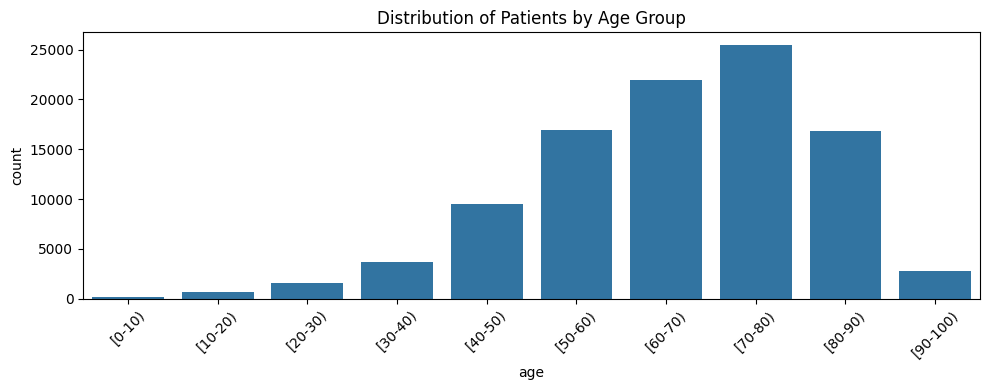

In [96]:
plt.figure(figsize=(10, 4))
age_order = ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)',
             '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']
sns.countplot(data=df_cleaned, x='age', order=age_order)
plt.title('Distribution of Patients by Age Group')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

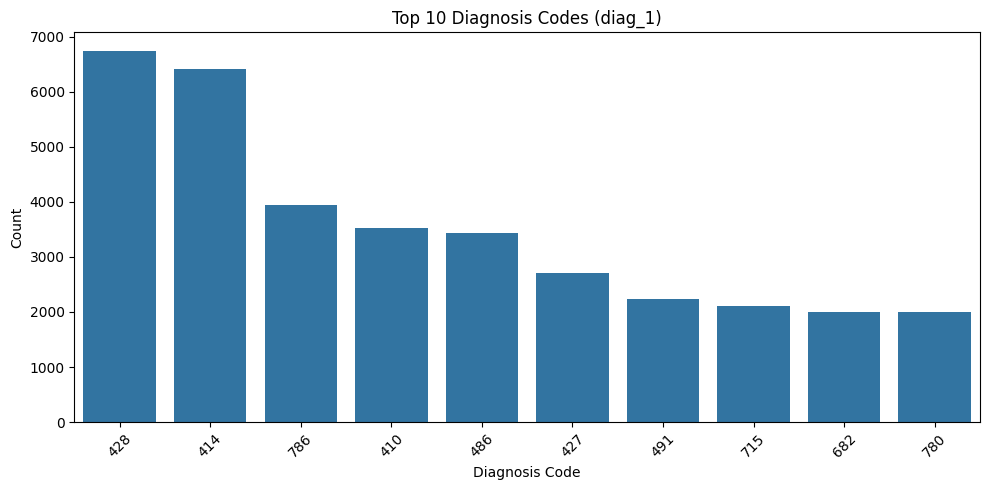

In [101]:
# 4. Top 10 most common diag_1 codes
plt.figure(figsize=(10, 5))
top_diag1 = df_cleaned['diag_1'].value_counts().head(10)
sns.barplot(x=top_diag1.index, y=top_diag1.values)
plt.title('Top 10 Diagnosis Codes (diag_1)')
plt.xlabel('Diagnosis Code')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

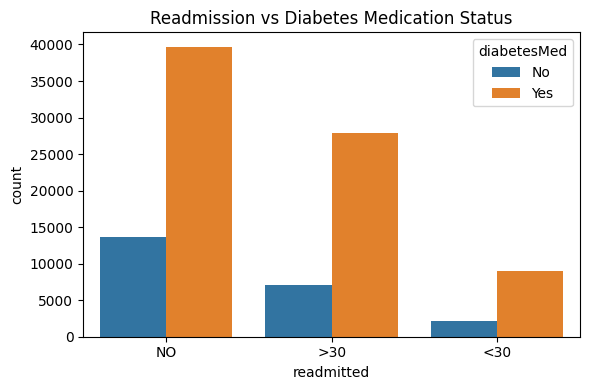

In [99]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df_cleaned, x='readmitted', hue='diabetesMed')
plt.title('Readmission vs Diabetes Medication Status')
plt.tight_layout()
plt.show()

In [108]:
# Relative frequency table (row-wise)
readmission_rel_freq = pd.crosstab(
    df_cleaned['diabetesMed'],
    df_cleaned['readmitted'],
    normalize='index'  # normalizes each row (i.e., per diabetesMed group)
)

# Optional: format as percentages
readmission_rel_freq_percent = (readmission_rel_freq * 100).round(2)

# Display table
display(Markdown("### Relative Frequency of Readmission per Diabetes Medication Status"))
display(readmission_rel_freq_percent)

### Relative Frequency of Readmission per Diabetes Medication Status

readmitted,<30,>30,NO
diabetesMed,,,
No,9.64,31.07,59.28
Yes,11.70,36.42,51.88


Text(0.5, 1.0, 'Readmission by Gender')

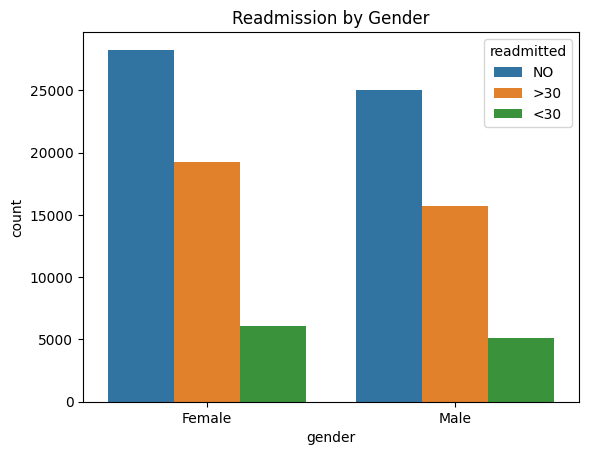

In [109]:
sns.countplot(data=df_cleaned, x='gender', hue='readmitted')
plt.title("Readmission by Gender")

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, '[0-10)'),
  Text(1, 0, '[10-20)'),
  Text(2, 0, '[20-30)'),
  Text(3, 0, '[30-40)'),
  Text(4, 0, '[40-50)'),
  Text(5, 0, '[50-60)'),
  Text(6, 0, '[60-70)'),
  Text(7, 0, '[70-80)'),
  Text(8, 0, '[80-90)'),
  Text(9, 0, '[90-100)')])

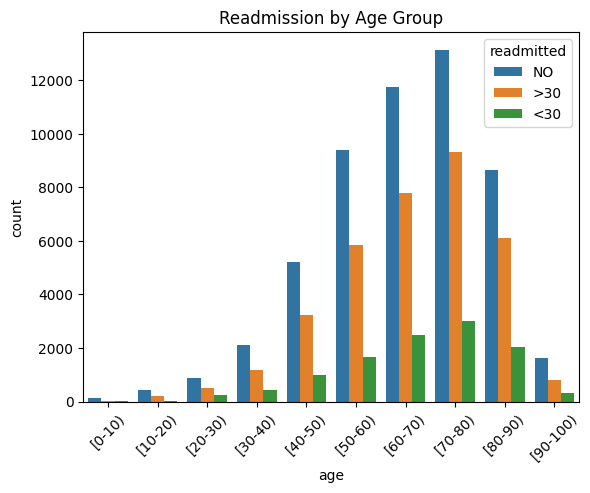

In [110]:
age_order = ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)',
             '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']
sns.countplot(data=df_cleaned, x='age', hue='readmitted', order=age_order)
plt.title("Readmission by Age Group")
plt.xticks(rotation=45)

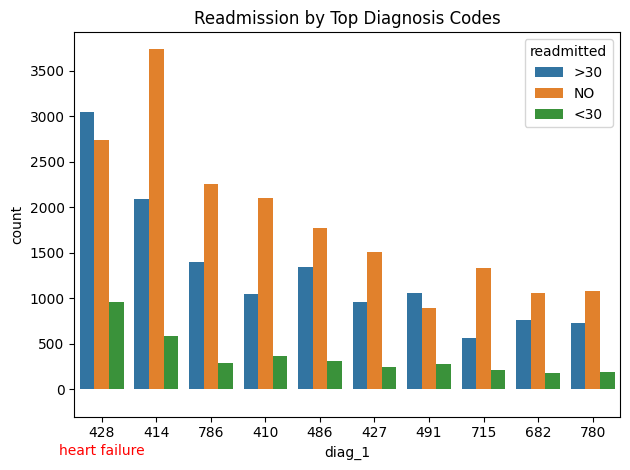

In [116]:
top_diag_list = list(top_diag)  # convert to list
x_pos = top_diag_list.index('428')  # x-position of "428"

sns.countplot(data=df_cleaned[df_cleaned['diag_1'].isin(top_diag_list)],
              x='diag_1', hue='readmitted', order=top_diag_list)
plt.title("Readmission by Top Diagnosis Codes")

plt.text(x=x_pos, y=-600, s='heart failure', ha='center', va='top', fontsize=10, color='red')
plt.ylim(bottom=-300)
plt.tight_layout()
plt.show()

# Encoding Nominal Variables
Encoding Categorical and Ordinal Variables

In [65]:
## Encoding Variables

# Binary or ordinal
df_cleaned['gender'] = df_cleaned['gender'].astype(str)
df_cleaned['gender'] = LabelEncoder().fit_transform(df_cleaned['gender'])

df_cleaned['readmitted'] = df_cleaned['readmitted'].map({'NO': 0, '>30': 0, '<30': 1})
df_cleaned['diabetesMed'] = df_cleaned['diabetesMed'].map({'No': 0, 'Yes': 1})
df_cleaned['change'] = df_cleaned['change'].map({'No': 0, 'Ch': 1})

# Ordinal: age group
age_order = {'[0-10)': 0, '[10-20)': 1, '[20-30)': 2, '[30-40)': 3, '[40-50)': 4,
             '[50-60)': 5, '[60-70)': 6, '[70-80)': 7, '[80-90)': 8, '[90-100)': 9}
df_cleaned['age'] = df_cleaned['age'].map(age_order)

In [66]:
## One-hot encoding Race

df_cleaned = pd.get_dummies(df_cleaned, columns=['race'], drop_first=True)

In [67]:
## Encoding medical columns as ordinal variables

med_columns = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
    'glimepiride', 'acetohexamide', 'glipizide', 'glyburide',
    'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
    'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
    'insulin', 'glyburide-metformin', 'glipizide-metformin',
    'glimepiride-pioglitazone', 'metformin-rosiglitazone',
    'metformin-pioglitazone'
]

med_mapping = {'No': 0, 'Down': 1, 'Steady': 2, 'Up': 3}

for col in med_columns:
    df_cleaned[col] = df_cleaned[col].map(med_mapping)


In [68]:
## Categorizing Diagnosis before encoding

for col in ['diag_1', 'diag_2', 'diag_3']:
    df_cleaned[col] = df_cleaned[col].astype(str).str[:3]

def categorize_diag(code):
    try:
        code = float(code)
        if code == 250:
            return 'Diabetes'
        elif 390 <= code <= 459 or code == 785:
            return 'Circulatory'
        elif 460 <= code <= 519 or code == 786:
            return 'Respiratory'
        elif 520 <= code <= 579 or code == 787:
            return 'Digestive'
        elif 800 <= code <= 999:
            return 'Injury'
        elif 290 <= code <= 319:
            return 'Mental Health'
        else:
            return 'Other'
    except:
        return 'Unknown'

for col in ['diag_1', 'diag_2', 'diag_3']:
    df_cleaned[col] = df_cleaned[col].map(categorize_diag)

In [69]:
## One-hot Encoding Diagnosis Variables

df_cleaned = pd.get_dummies(df_cleaned, columns=['diag_1', 'diag_2', 'diag_3'], drop_first=True)

In [70]:
df_cleaned.head()

,encounter_id,patient_nbr,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,...,diag_2_Other,diag_2_Respiratory,diag_2_Unknown,diag_3_Diabetes,diag_3_Digestive,diag_3_Injury,diag_3_Mental Health,diag_3_Other,diag_3_Respiratory,diag_3_Unknown
0,2278392,8222157,1,0,6,25,1,1,41,0,...,False,False,True,False,False,False,False,False,False,True
1,149190,55629189,1,1,1,1,7,3,59,0,...,False,False,False,False,False,False,False,True,False,False
2,64410,86047875,1,2,1,1,7,2,11,5,...,False,False,False,False,False,False,False,False,False,True
3,500364,82442376,2,3,1,1,7,2,44,1,...,False,False,False,False,False,False,False,False,False,False
4,16680,42519267,2,4,1,1,7,1,51,0,...,True,False,False,True,False,False,False,False,False,False


In [71]:
for col in df_cleaned.columns:
    print(f"Column: {col}")
    print(f"  Data type      : {df_cleaned[col].dtype}")
    print(f"  Unique values  : {df_cleaned[col].nunique()}")
    print("-" * 40)

Column: encounter_id
  Data type      : int64
  Unique values  : 99493
----------------------------------------
Column: patient_nbr
  Data type      : int64
  Unique values  : 69668
----------------------------------------
Column: gender
  Data type      : int64
  Unique values  : 3
----------------------------------------
Column: age
  Data type      : int64
  Unique values  : 10
----------------------------------------
Column: admission_type_id
  Data type      : int64
  Unique values  : 8
----------------------------------------
Column: discharge_disposition_id
  Data type      : int64
  Unique values  : 26
----------------------------------------
Column: admission_source_id
  Data type      : int64
  Unique values  : 17
----------------------------------------
Column: time_in_hospital
  Data type      : int64
  Unique values  : 14
----------------------------------------
Column: num_lab_procedures
  Data type      : int64
  Unique values  : 118
-------------------------------------

In [77]:
# Checking data in independent variable
print(df_cleaned['readmitted'].value_counts())

readmitted
0    88324
1    11169
Name: count, dtype: int64


# PCA Attempt
Upon analysis, we identified that PCA is not the best approach for categorical variables

In [72]:
## Executing PCA to reduce dimensionality

features = df_cleaned.drop(columns=['readmitted'])

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

In [73]:
# Initialize PCA (keep enough components to explain 95% of the variance)
pca = PCA(n_components=0.80)  # or choose a fixed number like n_components=10
X_pca = pca.fit_transform(X_scaled)


In [74]:
pca_columns = [f'PC{i+1}' for i in range(X_pca.shape[1])]
df_pca = pd.DataFrame(X_pca, columns=pca_columns)


In [75]:
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

print("Explained variance by each component:")
print(explained_variance)

print("\nCumulative explained variance:")
print(cumulative_variance)


Explained variance by each component:
[0.04350119 0.03544989 0.0310728  0.02783816 0.02643922 0.0245188
 0.02336129 0.02264604 0.02183998 0.02172683 0.02036533 0.01973354
 0.01874512 0.01835466 0.01793075 0.01783044 0.01751976 0.01732135
 0.01689215 0.01667863 0.01660403 0.01648875 0.01638134 0.01633457
 0.01625431 0.01618745 0.016164   0.01614401 0.0161285  0.01610884
 0.01609781 0.01608383 0.0160246  0.01589189 0.01572541 0.0156902
 0.01553883 0.01521689 0.01498218 0.01493286 0.0145907  0.01445997]

Cumulative explained variance:
[0.04350119 0.07895108 0.11002388 0.13786203 0.16430125 0.18882006
 0.21218135 0.23482738 0.25666736 0.27839419 0.29875952 0.31849306
 0.33723818 0.35559284 0.37352359 0.39135403 0.40887379 0.42619513
 0.44308728 0.45976591 0.47636994 0.49285869 0.50924003 0.52557461
 0.54182892 0.55801637 0.57418037 0.59032438 0.60645288 0.62256172
 0.63865953 0.65474336 0.67076796 0.68665985 0.70238527 0.71807547
 0.73361429 0.74883119 0.76381337 0.77874622 0.79333693 0.80

# Model Building - Logistic Regression
## Iteration 1 - Logistic Regression
Building a predictive model using Logistic Regression

In [76]:
# identifying dependent (y) and independent variables (x)

X = df_cleaned.drop(columns=['readmitted', 'encounter_id', 'patient_nbr'])
y = df_cleaned['readmitted']


In [78]:
# establishing train/test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [79]:
# fitting Logistic Regression model using liblinear optimization

model = LogisticRegression(max_iter=1000, solver='liblinear')
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000, solver='liblinear')

In [80]:
# Evaluating Classification through confusion matrix

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC AUC Score:", roc_auc_score(y_test, y_prob))


Confusion Matrix:
 [[17631    34]
 [ 2205    29]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     17665
           1       0.46      0.01      0.03      2234

    accuracy                           0.89     19899
   macro avg       0.67      0.51      0.48     19899
weighted avg       0.84      0.89      0.84     19899


ROC AUC Score: 0.6402203447682562


## Iteration 2 - Adjusting Class Weights


In [118]:
model = LogisticRegression(class_weight='balanced', solver='liblinear', max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear')

In [119]:
# Evaluating Classification after adjusting class weights

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC AUC Score:", roc_auc_score(y_test, y_prob))

Confusion Matrix:
 [[12036  5629]
 [ 1090  1144]]

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.68      0.78     17665
           1       0.17      0.51      0.25      2234

    accuracy                           0.66     19899
   macro avg       0.54      0.60      0.52     19899
weighted avg       0.83      0.66      0.72     19899


ROC AUC Score: 0.6414007233499418


## Iteration 3 - Oversampling using SMOTE


In [122]:
# Apply SMOTE to the training set
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

In [123]:
# Fitting the logistic regression
# No need to balance class weights, as it is already done through SMOTE

model = LogisticRegression(solver='liblinear', max_iter=1000)
model.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=1000, solver='liblinear')

In [124]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

[[14467  3198]
 [ 1766   468]]
              precision    recall  f1-score   support

           0       0.89      0.82      0.85     17665
           1       0.13      0.21      0.16      2234

    accuracy                           0.75     19899
   macro avg       0.51      0.51      0.51     19899
weighted avg       0.81      0.75      0.78     19899

ROC AUC Score: 0.5355945642073798
